# From GRPO to ExGRPO: Learning to Reason from Experience

In this notebook, we study how reinforcement learning can be applied to improve reasoning tasks in a controlled, interpretable setting. Our focus is on two closely related algorithms, GRPO (Group Relative Policy Optimization) and its extension ExGRPO (Experience-based GRPO), which were recently proposed to train models that learn to reason through verifiable rewards.

Publication: https://arxiv.org/pdf/2510.02245

## Background

In *reinforcement learning with verifiable rewards* (RLVR), a model generates multiple candidate answers for a given question, and a verifier determines whether each answer is correct. Unlike traditional reinforcement learning, there is no need to predict long-term returns, the correctness signal is immediate and explicit. This framework makes it possible to train reasoning models (such as LLMs) to refine their step-by-step thinking.

**GRPO** simplifies classical algorithms like PPO by removing the need for a separate value network. Instead, it estimates the advantage of each trajectory relative to others in the same group of samples for the same prompt. This simple normalization stabilizes training and works well in reasoning settings where rewards are binary or sparse. However, GRPO is strictly on-policy, once a batch of trajectories is used, all that experience is discarded. This makes learning inefficient, especially when correct or informative trajectories are rare.

## Motivation

**ExGRPO** addresses this limitation by introducing a replay buffer of successful reasoning trajectories. The algorithm selectively reuses past experiences, prioritizing confident and informative examples, and combines them with new on-policy rollouts. This mixture increases sample efficiency and improves stability without sacrificing exploration.

To illustrate these ideas, we will reproduce the core behavior of GRPO and ExGRPO on a small arithmetic reasoning task (addition and subtraction). The model acts as a simple policy network trained to predict the correct numerical result, receiving a reward based on how close its prediction is to the true answer. Through this controlled setup, we will visualize and compare how:
- GRPO learns slowly but steadily from on-policy rollouts,
- ExGRPO accelerates and stabilizes learning by leveraging past successful experiences.

Our objective is to understand, at an intuitive and experimental level, why ExGRPO outperforms GRPO, not through scale, but through a more efficient use of experience.

In [2]:
import math, random, collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## Dataset Construction

The dataset simulates simple arithmetic reasoning tasks (addition and subtraction) with automatically verifiable answers.
Each sample is built by randomly drawing two integers $a,b \in [-M,M]$ and an operation (“add” or “sub”). The correct answer $ans$ is computed as $a+b$ or $a-b$. Tasks whose result falls outside $[-M,M]$ are discarded to keep all answers within a consistent range.

Each task is represented as a feature vector $[a, b, 1_{\text{add}}, 1_{\text{sub}}]$, where the last two entries are one-hot indicators of the operation type. The dataset exposes an action space corresponding to all possible integer answers in $[\text{amin}, \text{amax}]$, enabling the policy to predict discrete outcomes. The functions `ans_to_act` and `act_to_ans` map between numeric answers and their action indices, allowing the model to reason in a discrete reinforcement-learning setting with verifiable rewards.

In [3]:
OPS = ["add", "sub"]

class Task:
    def __init__(self, a, b, op, ans, uid):
        self.a, self.b, self.op, self.ans, self.uid = a, b, op, ans, uid

def make_tasks(n, seed=0):
    random.seed(seed)
    tasks, uid = [], 0
    M = 20
    while len(tasks) < n:
        a = random.randint(-M, M)
        b = random.randint(-M, M)
        op = random.choice(OPS)
        ans = a + b if op == "add" else a - b
        if -M <= ans <= M:
            tasks.append(Task(a, b, op, ans, uid))
            uid += 1
    return tasks

class ReasoningDataset(Dataset):
    def __init__(self, tasks, amin, amax):
        self.tasks = tasks
        self.amin, self.amax = amin, amax
        self.nactions = amax - amin + 1
        
    def __len__(self): 
        return len(self.tasks)
        
    def __getitem__(self, i):
        t = self.tasks[i]
        feat = torch.tensor([t.a, t.b,
                             1.0 if t.op == "add" else 0.0,
                             1.0 if t.op == "sub" else 0.0], dtype=torch.float32)
        return dict(feat=feat, ans=t.ans, uid=t.uid)

        
    def ans_to_act(self, y):
        if y < self.amin or y > self.amax: return None
        return y - self.amin
        
    def act_to_ans(self, a): 
        return a + self.amin

## Policy Network

The Policy network is the model that learns to predict the correct arithmetic result, it plays the role of the agent in the reinforcement learning setup.

It takes as input the 4-dimensional feature vector $[a, b, 1_{\text{add}}, 1_{\text{sub}}]$ representing a reasoning task, and outputs a vector of size `n_actions`, which corresponds to the possible discrete answers (e.g. integers between `amin` and `amax`).

Formally, the last layer produces unnormalized logits:

$$
\text{logits} = f_\theta(a,b,1_{\text{add}},1_{\text{sub}}) \in \mathbb{R}^{n_\text{actions}},
$$

which are then turned into probabilities by a softmax:

$$
\pi_\theta(a'|x) = \text{softmax}(\text{logits}).
$$

This defines the policy $\pi_\theta$, the probability of choosing each possible answer given the input problem.

During training, GRPO or ExGRPO updates the parameters $\theta$ so that the policy assigns higher probability to correct answers, using verifiable rewards as feedback.


In [4]:
class Policy(nn.Module):
    def __init__(self, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, n_actions)
        )
    def forward(self, x): 
        return self.net(x)

## GRPO Utilities

These three functions implement the core mechanics of GRPO: how rollouts are generated, evaluated, and normalized before updating the policy.

### **`rollout_group`**

This function generates $K$ candidate answers (actions) for each input problem. Given the feature batch `feats`, the policy outputs logits for all possible answers. A categorical distribution $\pi_\theta(a|x)$ is created via `softmax`, from which $K$ actions are sampled per item. It returns:

- `actions`: the sampled answers,
- `logps`: their log-probabilities,
- `entropies`: the entropy of each policy distribution (a measure of uncertainty).
  This corresponds to performing *grouped rollouts*, multiple reasoning attempts per question.

### **`compute_rewards`**

Once actions are sampled, the environment evaluates them. Here the reward is verifiable and binary:

$$
r_{i,k} =
\begin{cases}
1, & \text{if predicted answer = true answer},\\
0, & \text{otherwise.}
\end{cases}
$$

This gives a matrix of rewards of shape $[B,K]$. It’s the “feedback” signal used by GRPO to learn which sampled trajectories were successful.

### **`group_adv`**

GRPO replaces the usual value baseline by *group-wise normalization*. For each question $i$, the mean and standard deviation of its $K$ rewards are computed:

$$
A_{i,k} = \frac{r_{i,k} - \bar{r}*i}{\sigma_i + \varepsilon}.
$$

These standardized values $A*{i,k}$ serve as the advantages used in the policy gradient. They emphasize relatively better rollouts within each question, stabilizing learning and removing the need for a learned value function.

In [5]:
def group_adv(rewards, eps=1e-8):
    m = rewards.mean(1, keepdim=True)
    s = rewards.std(1, keepdim=True).clamp_min(eps)
    return (rewards - m) / s

def rollout_group(policy, feats, K):
    logits = policy(feats)                     # [B, A]
    logp = F.log_softmax(logits, dim=-1)
    probs = logp.exp()
    dist = torch.distributions.Categorical(probs)
    actions = dist.sample((K,)).T             # [B, K]
    logps = logp.gather(1, actions)           # [B, K]
    entropies = -(probs * logp).sum(-1)       # [B]
    return actions, logps, entropies, logits

def compute_rewards(dataset, batch, actions):
    B, K = actions.size()
    rewards = torch.zeros(B, K, device=actions.device)
    for i in range(B):
        true = batch["ans"][i].item()
        for k in range(K):
            pred = dataset.act_to_ans(int(actions[i, k].item()))
            rewards[i, k] = 1.0 if pred == true else 0.0
    return rewards

## Experience Buffer

The experience buffer is the mechanism that enables ExGRPO to reuse valuable reasoning trajectories from previous epochs. Each trajectory stores all the relevant information from one reasoning attempt: the input features $x = [a, b, 1_{\text{add}}, 1_{\text{sub}}]$, the predicted action $a'$, its reward $r$, the log-probability $\log \pi_{\text{old}}(a'|x)$, the policy entropy $H(\pi_{\text{old}}(\cdot|x))$, and the training step $t$ at which it was collected. This allows the algorithm to recover not only what the model answered, but also how confident and recent that answer was.

The buffer acts as a prioritized memory of successful reasoning episodes. A trajectory $\tau = (x, a', r, \log \pi_{\text{old}}, H, t)$ is added only if its reward satisfies $r = 1$, ensuring that only verified correct outcomes are stored. For each question identifier $u$, at most $C$ trajectories are kept to preserve diversity. When the buffer $\mathcal{B}$ exceeds its capacity $L_{\max}$, the oldest samples are removed so that

$$
|\mathcal{B}| \le L_{\max}, \qquad
|{\tau \in \mathcal{B}: \tau.\text{uid}=u}| \le C.
$$

During sampling, each stored trajectory is assigned a priority weight that favors recency, confidence, and correctness:

$$
w(\tau) = \exp(-\frac{\text{age}(\tau)}{\tau_{\text{rec}}}) \cdot \frac{r}{1 + H},
$$

where $\text{age}(\tau) = \text{now} - t$ and $\tau_{\text{rec}}$ controls the rate of temporal decay. The buffer returns the highest-weight trajectories with distinct identifiers, producing a diverse batch of past successes. These samples are then used for off-policy updates in ExGRPO, allowing the policy to reinforce correct reasoning steps multiple times instead of discarding them after one use.


In [6]:
class Traj:
    def __init__(self, uid, feat, act, reward, logp, ent, step):
        self.uid = uid; self.feat = feat; self.act = act; self.reward = reward
        self.logp = logp; self.ent = ent; self.step = step

class Buffer:
    def __init__(self, maxlen=3000, per_uid_cap=3):
        self.trajs = [] 
        self.maxlen = maxlen
        self.per_uid_cap = per_uid_cap

    def add(self, tr: Traj):
        if tr.reward < 1.0:
            return
        count = sum(1 for t in self.trajs if t.uid == tr.uid)
        if count >= self.per_uid_cap:
            return
        self.trajs.append(tr)
        if len(self.trajs) > self.maxlen:
            self.trajs = self.trajs[-self.maxlen:]

    def retire_by_uids(self, uids):
        self.trajs = [t for t in self.trajs if t.uid not in uids]

    def sample(self, per=128, now=0, tau=200):
        cand = []
        for t in self.trajs:
            age = max(1, now - t.step)
            w = math.exp(-age / float(tau)) * t.reward / (1.0 + t.ent)
            cand.append((w, t))
        cand.sort(key=lambda x: x[0], reverse=True)
        seen, out = set(), []
        for _, t in cand:
            if t.uid in seen:
                continue
            out.append(t)
            seen.add(t.uid)
            if len(out) >= per:
                break
        return out

## Training / Evaluation with schedules and anti-staleness tricks

One defines here the full training and evaluation loop for GRPO and ExGRPO. The goal is to alternate between exploration, collecting new rollouts, and exploitation, reusing successful past trajectories, while controlling their relative influence with adaptive schedules.

The function `mix_schedule` defines the coefficient $\lambda(e)$ that determines the balance between on-policy and off-policy learning at epoch $e$. It increases after a warm-up period, reaches a peak, then slowly decays:

$$
\lambda(e) =
\begin{cases}
0, & e \le \text{warm}, \\
\min(\lambda_{\max}, \alpha(e-\text{warm})), & \text{warm} < e \le \text{peak}, \\
\max(\lambda_{\min}, \lambda_{\max}-\beta(e-\text{peak})), & e > \text{peak}.
\end{cases}
$$

This schedule allows ExGRPO to start like pure GRPO, then progressively integrate more replay samples once enough good trajectories have been collected.

In [7]:
def mix_schedule(ep, warm=5, peak=40, lam_max=0.5, lam_min=0.2, alpha=0.03, beta=0.01):
    if ep <= warm: return 0.0
    if ep <= peak: return min(lam_max, alpha * (ep - warm))
    val = max(lam_min, lam_max - beta * (ep - peak))
    return val

The function `isclip_schedule` controls the clipping constant $c(e)$ used in importance sampling weights

$$
w = \exp(\log\pi_\theta(a|x) - \log\pi_{\text{old}}(a|x))
$$
$$
\text{clamped to } [0, c(e)].
$$

Early in training, when the policy changes quickly, a high clip value $c_{\text{hi}}$ keeps updates flexible. Later, as the policy stabilizes, it switches to a lower bound $c_{\text{lo}}$ to prevent bias from stale trajectories.

The evaluation routine computes accuracy by comparing the model’s most probable action $\hat a=\arg\max_a\pi_\theta(a|x)$ to the true answer. Accuracy is measured over the validation set after each epoch:

$$
\text{acc} = \frac{1}{N} \sum_i \mathbf{1} [\text{act\_to\_ans}(\hat a_i)=y_i]
$$



In [8]:
def isclip_schedule(ep, turn=80, hi=5.0, lo=2.0):
    return hi if ep < turn else lo

The main `train` function integrates these elements. Each epoch draws mini-batches of features $x$ and performs $K$ rollouts per item. The policy is updated by minimizing

$$
\mathcal L_{\text{on}} = -\mathbb E[A_{i,k}\log\pi_\theta(a_{i,k}|x_i)],
$$

and, if ExGRPO is used, mixes in an off-policy term weighted by $\lambda(e)$:

$$
\mathcal L_{\text{off}} = -\mathbb E[w \log\pi_\theta(a|x)] + \beta \mathrm{KL}(\pi_\theta(\cdot|x) || \pi_{\text{curr}}(\cdot|x)),
$$

$$
\mathcal L_{\text{total}} = (1-\lambda) \mathcal L_{\text{on}} + \lambda \mathcal L_{\text{off}}.
$$

Gradients are clipped to $|\nabla_\theta|\le 1$ for stability. After each epoch, validation accuracy is logged and the model tracks improvement to detect plateaus. This structured combination of on-policy learning, scheduled replay, and regularized updates prevents catastrophic forgetting and maintains steady progress throughout training.


In [30]:
def evaluate(pol, loader, data, device):
    pol.eval(); c = 0; t = 0
    with torch.no_grad():
        for b in loader:
            f = b["feat"].to(device)
            pred = pol(f).argmax(-1)
            for i in range(len(pred)):
                if data.act_to_ans(pred[i].item()) == b["ans"][i].item(): c += 1
                t += 1
    pol.train(); 
    return c / max(1, t)

def train(cfg, algo, train_ds, val_ds):
    device = cfg["device"]
    torch.manual_seed(cfg["seed"]); np.random.seed(cfg["seed"]); random.seed(cfg["seed"])

    policy = Policy(train_ds.nactions).to(device)
    opt = torch.optim.Adam(policy.parameters(), lr=cfg["lr"])
    loader = DataLoader(train_ds, batch_size=cfg["bs"], shuffle=True, drop_last=True)
    vloader = DataLoader(val_ds, batch_size=1024, shuffle=False)

    buf = Buffer(maxlen=cfg["buf_maxlen"], per_uid_cap=cfg["uid_cap"])
    metrics, best_val = [], 0.0
    plateau_epochs, last_best_epoch = 0, 0
    global_step = 0

    for ep in range(1, cfg["epochs"] + 1):
        hard_first = False
        for batch in loader:
            feats = batch["feat"].to(device)
            B = feats.size(0)

            # on-policy rollouts
            acts, logps, ents, logits = rollout_group(policy, feats, K=cfg["K"])
            rew = compute_rewards(train_ds, batch, acts)

            # GRPO on-policy loss
            adv = group_adv(rew)
            loss_on = -(logps * adv.detach()).mean()

            # store successes for ExGRPO
            if algo == "exgrpo":
                for i in range(B):
                    for k in range(cfg["K"]):
                        if rew[i, k].item() >= 1.0:
                            tr = Traj(
                                uid=batch["uid"][i].item(),
                                feat=feats[i].detach().cpu(),
                                act=int(acts[i, k].item()),
                                reward=float(rew[i, k].item()),
                                logp=float(logps[i, k].detach().cpu().item()),
                                ent=float(ents[i].detach().cpu().item()),
                                step=global_step
                            )
                            buf.add(tr)

            # off-policy replay
            loss = loss_on
            if algo == "exgrpo":
                lam = mix_schedule(ep, warm=cfg["warm"], peak=cfg["peak"], 
                                   lam_max=cfg["mix_max"], lam_min=cfg["mix_min"],
                                   alpha=cfg["mix_alpha"], beta=cfg["mix_beta"])
                if lam > 0.0:
                    is_clip = isclip_schedule(ep, turn=cfg["is_turn"], hi=cfg["is_hi"], lo=cfg["is_lo"])
                    trajs = buf.sample(per=cfg["per"], now=global_step, tau=cfg["recency_tau"])
                    if trajs:
                        f = torch.stack([t.feat for t in trajs]).to(device)
                        a = torch.tensor([t.act for t in trajs], dtype=torch.long, device=device)
                        lp_old = torch.tensor([t.logp for t in trajs], dtype=torch.float32, device=device)

                        logits_off = policy(f)
                        logp_all = F.log_softmax(logits_off, dim=-1)
                        lp_new = logp_all.gather(1, a.view(-1,1)).squeeze(1)

                        # importance sampling with clipping
                        w = torch.exp(lp_new - lp_old).clamp(0., is_clip)

                        # light KL reg (to current logits)
                        with torch.no_grad():
                            logits_curr = policy(f)
                            p_curr = F.softmax(logits_curr, dim=-1)
                        kl = (p_curr * (logp_all - torch.log(p_curr + 1e-8))).sum(dim=1).mean()

                        loss_off = -(w.detach() * lp_new).mean() + cfg["kl_beta"] * kl
                        loss = (1 - lam) * loss_on + lam * loss_off

            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
            opt.step()
            global_step += 1

        # evaluate each epoch
        acc = evaluate(policy, vloader, val_ds, device)
        metrics.append(acc)
        print(f"[{algo.upper()}] epoch {ep:03d}  val_acc={acc:.4f}")

        # plateau tracking to trigger harder-first replay and retire solved
        if acc > best_val + 1e-4:
            best_val = acc
            last_best_epoch = ep
        else:
            plateau_epochs = ep - last_best_epoch

    return metrics

## Run GRPO and ExGRPO

### Create train/test Datasets

Each line represents one reasoning task from the train dataset, every sample is a dictionary with three keys:

- **`feat`** → a 4-dimensional tensor encoding the input problem,
- **`ans`** → the correct numerical answer,
- **`uid`** → a unique identifier for this specific task.

#### Examples

- 'feat': `tensor([16., 16., 0., 1.])` → This means (a = 16), (b = 16).
The last two entries `[0., 1.]` are the one-hot encoding of the operation: `[1, 0]` for *addition*, `[0, 1]` for *subtraction*.
So here `op = "sub"`. The correct answer `'ans': 0` confirms that (16 - 16 = 0).


- 'feat': `tensor([6., 5., 1., 0.])` → (a = 6, b = 5), and `[1, 0]` means addition.
Thus the problem is (6 + 5 = 11), which matches `'ans': 11`.

In [32]:
all_tasks = make_tasks(n=10000, seed=0)
random.shuffle(all_tasks)
split = int(0.8 * len(all_tasks))
train_ds = ReasoningDataset(all_tasks[:split], amin=-10, amax=10)
val_ds = ReasoningDataset(all_tasks[split:],  amin=-10, amax=10)

for i in range(10):
    sample = train_ds[i]
    print(f"Sample {i}: {sample}")

Sample 0: {'feat': tensor([16., 16.,  0.,  1.]), 'ans': 0, 'uid': 2266}
Sample 1: {'feat': tensor([6., 5., 1., 0.]), 'ans': 11, 'uid': 6607}
Sample 2: {'feat': tensor([ -7., -13.,   0.,   1.]), 'ans': 6, 'uid': 1832}
Sample 3: {'feat': tensor([17., -1.,  1.,  0.]), 'ans': 16, 'uid': 5134}
Sample 4: {'feat': tensor([14., -4.,  1.,  0.]), 'ans': 10, 'uid': 7217}
Sample 5: {'feat': tensor([-13.,  -5.,   1.,   0.]), 'ans': -18, 'uid': 7089}
Sample 6: {'feat': tensor([-15.,   1.,   1.,   0.]), 'ans': -14, 'uid': 2635}
Sample 7: {'feat': tensor([ 12., -14.,   1.,   0.]), 'ans': -2, 'uid': 8541}
Sample 8: {'feat': tensor([5., 4., 1., 0.]), 'ans': 9, 'uid': 3432}
Sample 9: {'feat': tensor([-15.,  -1.,   1.,   0.]), 'ans': -16, 'uid': 4504}


### Training configuration

The first block defines **general training settings**.

* `device` selects whether to train on GPU or CPU.
* `lr = 3e-4` is the learning rate for the Adam optimizer, determining how fast the policy parameters update each step.
* `bs = 128` sets the batch size, i.e., the number of problems processed before each gradient update.
* `K = 16` is the number of rollouts per question, meaning each problem is sampled sixteen times to compute group-based advantages in GRPO.
* `epochs = 50` specifies how many full passes over the dataset will be performed.
* `seed = 0` ensures reproducibility by fixing the random number generator state.

---

The next section defines **replay and scheduling parameters** for ExGRPO.

* `warm = 5` indicates the number of initial epochs using pure GRPO before enabling replay.
* `peak = 40` sets the epoch where the replay mix coefficient reaches its maximum.
* `mix_max = 0.5` and `mix_min = 0.2` define the upper and lower bounds of the replay mixing weight $\lambda$ that controls how much off-policy data influences training.
* `mix_alpha = 0.03` and `mix_beta = 0.01` determine how fast this coefficient grows and decays across epochs.
  These parameters together shape the schedule
  $$
  \lambda(e) \in [\lambda_{\min}, \lambda_{\max}],
  $$
  which gradually increases replay influence and then stabilizes.

---

The **importance sampling schedule** controls how aggressively off-policy updates are corrected.

* `is_turn = 25` marks the epoch when the clipping constant changes.
* `is_hi = 5.0` and `is_lo = 2.0` define the clipping range $w = \exp(\log \pi_\theta - \log \pi_{\text{old}})$ used in importance sampling, with tighter clipping after epoch 25 to prevent instability from outdated samples.

---

The remaining parameters configure the **experience buffer**.

* `per = 256` is the number of replay trajectories drawn at each sampling step.
* `recency_tau = 300.0` is the temporal decay constant in
  $$
  w(\tau) = \exp(-\text{age}(\tau)/\tau_{\text{rec}}) \cdot \frac{r}{1 + H},
  $$
  favoring recent, confident successes.
* `buf_maxlen = 3000` sets the maximum buffer capacity,
* `uid_cap = 3` limits how many trajectories can be stored for each unique problem, maintaining diversity.
* `kl_beta = 1e-3` weights the small KL regularization term that keeps replayed updates close to the current policy distribution.

In [33]:
cfg = dict(
    device="cuda" if torch.cuda.is_available() else "cpu",
    lr=3e-4, bs=128, K=16, epochs=50, seed=0,
    
    # replay config
    warm=5, peak=25, mix_max=0.5, mix_min=0.2, mix_alpha=0.03, mix_beta=0.01,
    is_turn=25, is_hi=5.0, is_lo=2.0,
    per=256, recency_tau=300.0, buf_maxlen=3000, uid_cap=3,
    kl_beta=1e-3
)

Training GRPO...
[GRPO] epoch 001  val_acc=0.0860
[GRPO] epoch 002  val_acc=0.1375
[GRPO] epoch 003  val_acc=0.1595
[GRPO] epoch 004  val_acc=0.1715
[GRPO] epoch 005  val_acc=0.2045
[GRPO] epoch 006  val_acc=0.2060
[GRPO] epoch 007  val_acc=0.2015
[GRPO] epoch 008  val_acc=0.2595
[GRPO] epoch 009  val_acc=0.2685
[GRPO] epoch 010  val_acc=0.3030
[GRPO] epoch 011  val_acc=0.2980
[GRPO] epoch 012  val_acc=0.2975
[GRPO] epoch 013  val_acc=0.3270
[GRPO] epoch 014  val_acc=0.3130
[GRPO] epoch 015  val_acc=0.3040
[GRPO] epoch 016  val_acc=0.3405
[GRPO] epoch 017  val_acc=0.3385
[GRPO] epoch 018  val_acc=0.3340
[GRPO] epoch 019  val_acc=0.3485
[GRPO] epoch 020  val_acc=0.3415
[GRPO] epoch 021  val_acc=0.3605
[GRPO] epoch 022  val_acc=0.3590
[GRPO] epoch 023  val_acc=0.3380
[GRPO] epoch 024  val_acc=0.3215
[GRPO] epoch 025  val_acc=0.3410
[GRPO] epoch 026  val_acc=0.3545
[GRPO] epoch 027  val_acc=0.3645
[GRPO] epoch 028  val_acc=0.3505
[GRPO] epoch 029  val_acc=0.3575
[GRPO] epoch 030  val_acc=

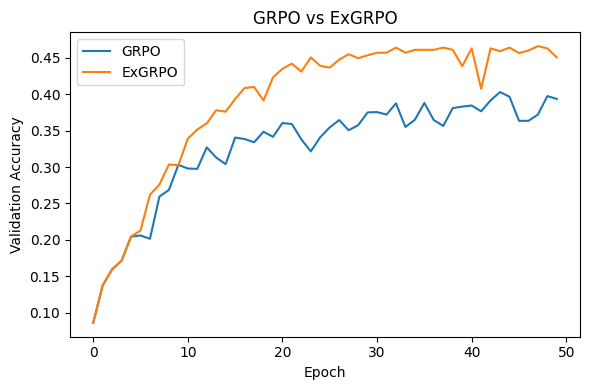


Final Val Acc | GRPO: 0.3935 ExGRPO: 0.4505


In [34]:
print("Training GRPO...")
acc_grpo = train(cfg, "grpo", train_ds, val_ds)
print("Training ExGRPO...")
acc_exgrpo = train(cfg, "exgrpo", train_ds, val_ds)

# plot
plt.figure(figsize=(6,4))
plt.plot(acc_grpo, label="GRPO")
plt.plot(acc_exgrpo, label="ExGRPO")
plt.xlabel("Epoch"); plt.ylabel("Validation Accuracy")
plt.title("GRPO vs ExGRPO")
plt.legend(); plt.tight_layout(); plt.show()

# summary
print("\nFinal Val Acc | GRPO: {:.4f} ExGRPO: {:.4f}".format(acc_grpo[-1], acc_exgrpo[-1]))

## Analysis

This figure compares the validation accuracy of GRPO and ExGRPO across 50 training epochs. Both methods show the expected upward trend during early learning, but ExGRPO achieves consistently higher accuracy after the first ten epochs and maintains a clear lead throughout training. 

The faster rise and smoother plateau of ExGRPO indicate that the algorithm benefits from reusing past successful trajectories: experience replay provides denser gradient signals and reduces variance in policy updates. GRPO, being purely on-policy, learns more slowly and exhibits stronger fluctuations, a signature of higher gradient noise.

By the end of training, ExGRPO reaches about 45% validation accuracy compared to 39% for GRPO, a meaningful improvement that demonstrates its superior sample efficiency and stability when reasoning from prior experience.